In [ ]:
import pandas as pd
import riotwatcher

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')

In [10]:
api_key = "RGAPI-ac338d67-3758-423d-8aed-d3c722a7fe3c"

In [11]:
lolwatcher = riotwatcher.LolWatcher(api_key=api_key)

In [12]:
summoner_name = "정신력남자"
region = "ASIA"
server = "KR"
count = 100
queue = 420

In [13]:
puuid = lolwatcher.summoner.by_name(region=server, summoner_name=summoner_name)["puuid"]
puuid

'yHkoNLe-mR186rkynN39frLVYFq3VvaFHlBrYqZvgslFXFaKPR7FxsE2h3lPavilFnOduruwyjhD5Q'

In [14]:
match_list = lolwatcher.match.matchlist_by_puuid(region=region, puuid=puuid, count=count, queue=queue)
match_list

['KR_6807587968',
 'KR_6807583215',
 'KR_6807566419',
 'KR_6807549124',
 'KR_6807525202',
 'KR_6807491827',
 'KR_6807457805',
 'KR_6807436448',
 'KR_6807369915',
 'KR_6807292160',
 'KR_6806211091',
 'KR_6806197538',
 'KR_6806188460',
 'KR_6806178635',
 'KR_6806169490',
 'KR_6806162185',
 'KR_6806151648',
 'KR_6806142780',
 'KR_6806128569',
 'KR_6806109349',
 'KR_6802420097',
 'KR_6802412088',
 'KR_6802398237',
 'KR_6802385080',
 'KR_6802359571',
 'KR_6802338227',
 'KR_6802300416',
 'KR_6802262157',
 'KR_6802199102',
 'KR_6802124922',
 'KR_6802047324',
 'KR_6800708990',
 'KR_6800715104',
 'KR_6800698682',
 'KR_6800687820',
 'KR_6800678773',
 'KR_6800673762',
 'KR_6800660720',
 'KR_6800647105',
 'KR_6800634110',
 'KR_6800598370',
 'KR_6800560002',
 'KR_6800469372',
 'KR_6800393612',
 'KR_6799093864',
 'KR_6799081869',
 'KR_6799065777',
 'KR_6799046946',
 'KR_6799030022',
 'KR_6798986605',
 'KR_6798952623',
 'KR_6797606924',
 'KR_6797607086',
 'KR_6797585976',
 'KR_6797568468',
 'KR_67975

In [15]:
def get_game_data(match_id):
    return lolwatcher.match.by_id(region=region, match_id=match_id)

In [16]:
def is_on_blue_side(game_data, puuid):
    participant_index = game_data["metadata"]["participants"].index(puuid)
    return True if game_data["info"]["participants"][participant_index]["teamId"] == 100 else False

In [17]:
def get_game_duration_m(game_data):
    return game_data["info"]["gameDuration"] // 60

In [18]:
def did_win(game_data, participant_index):
    return game_data["info"]["participants"][participant_index]["win"]

In [19]:
def get_time_line(match_id):
    return lolwatcher.match.timeline_by_match(region=region, match_id=match_id)

def get_participant_index(time_line, puuid, is_time_line):
    participant_index =  time_line["metadata"]["participants"].index(puuid)
    return participant_index + 1 if is_time_line else participant_index

In [20]:
def print_champion_stats(time_line, participant_index):
    champion_stats = time_line["info"]["frames"][0]["participantFrames"][str(participant_index)]["championStats"]
    for stat in ["healthMax", "armor", "magicResist", "movementSpeed"]:
        print(f"{stat}: {champion_stats[stat]}")

In [21]:
def get_total_gold_dicts(time_line, participant_index, is_blue_side, game_duration, game_won):

    add = 5 if is_blue_side else -5

    noway_total_gold_dict = {"win": game_won}
    lane_opponent_total_gold_dict = {"win": not game_won}
    for i in range(game_duration):
        participant_frames = time_line["info"]["frames"][i]["participantFrames"]

        noway_total_gold = participant_frames[str(participant_index)]["totalGold"]
        noway_total_gold_dict[f"min{i}"] =  noway_total_gold

        lane_opponent_total_gold = participant_frames[str(participant_index + add)]["totalGold"]
        lane_opponent_total_gold_dict[f"min{i}"] =  lane_opponent_total_gold

    return noway_total_gold_dict, lane_opponent_total_gold_dict

In [22]:
noway_gold = []
opponent_gold = []
for match_id in match_list:
    game_data = get_game_data(match_id)

    is_blue_side = is_on_blue_side(game_data, puuid)
    game_duration = get_game_duration_m(game_data)

    time_line = get_time_line(match_id)
    participant_index_time_line = get_participant_index(time_line, puuid, is_time_line=True)
    participant_index = get_participant_index(time_line, puuid, is_time_line=False)

    game_won = did_win(game_data, participant_index)

    # print_champion_stats(time_line, participant_index_time_line)
    # print("-------------------------")

    gold_dicts = get_total_gold_dicts(time_line, participant_index_time_line, is_blue_side, game_duration, game_won)

    noway_gold.append(gold_dicts[0])
    opponent_gold.append(gold_dicts[1])

KeyboardInterrupt: 

In [ ]:
noway_gold_df = pd.DataFrame(noway_gold)
opponent_gold_df = pd.DataFrame(opponent_gold)

filt_noway_win = noway_gold_df["win"]
filt_opponent_lose = opponent_gold_df["win"] == False

noway_win_df = noway_gold_df.loc[filt_noway_win]
opponent_lose_df = opponent_gold_df.loc[filt_opponent_lose]

# noway_win_df
# opponent_lose_df


noway_df_selected = noway_gold_df.loc[:, noway_gold_df.columns != "win"]
opponent_df_selected = opponent_gold_df.loc[:, opponent_gold_df.columns != "win"]

difference_gold_df = noway_df_selected - opponent_df_selected
difference_gold_df["win"] = noway_gold_df["win"]
difference_gold_df

In [ ]:
filt = (difference_gold_df["min10"] <= -500)
games = difference_gold_df.loc[filt, ["min10", "win"]].shape[0]
difference_gold_df.loc[filt, "win"].sum() / games

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Transponieren Sie das DataFrame, damit jede Zeile eine separate Linie wird
# df_transposed = noway_gold_df.T

# Plot erstellen
plt.figure(figsize=(15, 6))  # Sie können die Größe anpassen

wins = difference_gold_df["win"].values

# Iteriere über Zeilen und plote jeden Graphen
for index, row in difference_gold_df.iterrows():
    did_win = row["win"]
    row.drop('win', inplace=True)

    color = "blue" if did_win else "red"

    plt.plot(row, label=index, color=color)


custom_legend = [
    plt.Line2D([0], [0], color='blue', linestyle='-', markersize=8),
    plt.Line2D([0], [0], color='red', linestyle='-', markersize=8)
]

# Set the custom legend labels
legend_labels = ['in Wins', 'in Loses']

# Add the legend to the plot
plt.legend(custom_legend, legend_labels)

# Achsentitel und Legende hinzufügen
plt.xlabel('Minute')
plt.ylabel('Gold')
plt.title('Individuelle Gold Differenz gegenüber Lane Gegner über die Zeit')
# minutes = [x for x in range(0, 50, 1)]
# plt.xticks(minutes, labels=minutes)
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
# Plot anzeigen
plt.show()


In [ ]:
noway_gold_df[["min5", "min10", "min15", "min20"]].mean()
print("Gold von Minute 5 bis 10: ", 3555.243590 - 1637.000000)
print("Gold von Minute 10 bis 15: ", 5815.097222 - 3555.243590)
print("Gold von Minute 15 bis 20: ", 8171.507463 - 5815.097222)

In [ ]:
filt = noway_gold_df["win"]
noway_gold_df.loc[filt, ["min5", "min10", "min15", "min20"]].mean()

In [ ]:
noway_gold_df.loc[~filt, ["min5", "min10", "min15", "min20"]].mean()

In [ ]:
time_line = get_time_line(match_list[0])
# participant_index = get_participant_index(time_line, puuid, is_time_line=True)

def get_positions(time_line, participant_index):
    points = {"x": [], "y": []}
    for i in range(24):
        position = time_line["info"]["frames"][i]["participantFrames"][str(participant_index)]["position"]
        points["x"].append(position["x"])
        points["y"].append(position["y"])
    return points

In [ ]:
# import matplotlib.pyplot as plt

# ROLES = ["Top", "Jungle", "Middle", "Bottom", "Support"]


# for i in range(1, 6):
#     points = get_positions(time_line, i)

#     # Plot erstellen
#     plt.plot(points['x'], points['y'], marker='o', linestyle='-', color='b')

#     # Achsentitel hinzufügen
#     plt.xlabel('X-Koordinate')
#     plt.ylabel('Y-Koordinate')
#     plt.title(f'Heat-Map: {ROLES[i - 1]}')

#     plt.xticks([x for x in range(0, 14000, 500)], rotation=45)
#     plt.yticks([x for x in range(0, 14000, 500)])

#     # Plot anzeigen
#     plt.show()
#     # input()

In [ ]:
match_id = match_list[0]
time_line = get_time_line(match_id)

game_data = get_game_data(match_id)
get_participant_index(time_line, puuid, is_time_line=False)
for i in range(10):
    print(game_data["info"]["participants"][i]["championName"])

In [24]:
def print_in_game_time(time_stamp, message):
    minutes = int(time_stamp)
    seconds = int((time_stamp - minutes) * 60)
    print(message, end="\t")
    print(f"ingame time: {minutes}:{seconds}")
    return minutes

In [25]:
participant_index = get_participant_index(time_line, puuid, is_time_line=True)
# participant_index = 7

spawn_x_y = time_line["info"]["frames"][0]["participantFrames"][str(participant_index)]["position"]

points = []
point_dict = {"x": [], "y": []}

for frame in time_line["info"]["frames"]:
    for event in frame["events"]:
        if event["type"] == "CHAMPION_KILL" and event["victimId"] == participant_index:
            print_in_game_time(event["timestamp"] / 60000, "KILLED")
            points.append(point_dict)
            point_dict = {"x": [spawn_x_y["x"]], "y": [spawn_x_y["y"]]}
            break

        if event["type"] == "ITEM_PURCHASED" and event["participantId"] == participant_index:
            minutes = print_in_game_time(event["timestamp"] / 60000, "BASED")
            if minutes < 1:
                continue
            points.append(point_dict)
            point_dict = {"x": [spawn_x_y["x"]], "y": [spawn_x_y["y"]]}
            break

        if event["type"] == "CHAMPION_KILL":
            if participant_index == event["killerId"] or ("assistingParticipantIds" in event.keys() and (participant_index in event["assistingParticipantIds"])):
                print_in_game_time(event["timestamp"] / 60000, "KILL OR ASSIST")
                position = event["position"]
                point_dict["x"].append(position["x"])
                point_dict["y"].append(position["y"])
        
        if event["type"] == "BUILDING_KILL":
            if participant_index == event["killerId"] or ("assistingParticipantIds" in event.keys() and (participant_index in event["assistingParticipantIds"])):
                print_in_game_time(event["timestamp"] / 60000, "TURRET KILL")
                position = event["position"]
                point_dict["x"].append(position["x"])
                point_dict["y"].append(position["y"])

        if event["type"] == "CHAMPION_SPECIAL_KILL" and event["killerId"] == participant_index:
            print_in_game_time(event["timestamp"] / 60000, "SPECIAL KILL")
            position = event["position"]
            point_dict["x"].append(position["x"])
            point_dict["y"].append(position["y"])

        if event["type"] == "ELITE_MONSTER_KILL":
            if participant_index == event["killerId"] or ("assistingParticipantIds" in event.keys() and (participant_index in event["assistingParticipantIds"])):
                print_in_game_time(event["timestamp"] / 60000, "ELITE MONSTER KILL")
                position = event["position"]
                point_dict["x"].append(position["x"])
                point_dict["y"].append(position["y"])

        if event["type"] == "TURRET_PLATE_DESTROYED" and participant_index == event["killerId"]:
            print_in_game_time(event["timestamp"] / 60000, "TURRET_PLATE_DESTROYED")
            position = event["position"]
            point_dict["x"].append(position["x"])
            point_dict["y"].append(position["y"])


    position = frame["participantFrames"][str(participant_index)]["position"]
    point_dict["x"].append(position["x"])
    point_dict["y"].append(position["y"])

BASED	ingame time: 0:3
BASED	ingame time: 0:4
BASED	ingame time: 0:4
BASED	ingame time: 0:4
KILL OR ASSIST	ingame time: 2:36
KILLED	ingame time: 2:40
ELITE MONSTER KILL	ingame time: 6:5
BASED	ingame time: 6:35
KILL OR ASSIST	ingame time: 7:26
BASED	ingame time: 8:28
KILL OR ASSIST	ingame time: 9:56
BASED	ingame time: 10:32
KILL OR ASSIST	ingame time: 11:42
KILL OR ASSIST	ingame time: 13:0
KILLED	ingame time: 13:10
BASED	ingame time: 15:4
KILLED	ingame time: 16:11
KILLED	ingame time: 18:7
KILLED	ingame time: 21:27
KILLED	ingame time: 22:55
KILL OR ASSIST	ingame time: 23:36
KILLED	ingame time: 23:39


In [50]:
import pandas as pd

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(points)

# Transpose the DataFrame
df_transposed = df.transpose()

# Display the transposed DataFrame
df_transposed


,0,1,2,3,4,5,6,7,8,9,10
x,"[14281, 10717, 12934, 12311]","[14281, 13212, 12050, 13104, 8702, 9889]","[14281, 7085, 10233, 8954]","[14281, 3750, 9940, 9541]","[14281, 10527, 13692, 11181, 10082, 9774]","[14281, 11852, 13728]","[14281, 9551]","[14281, 8454, 9759]","[14281, 6675, 9760, 4780]","[14281, 10575]","[14281, 12223, 13300]"
y,"[14199, 4759, 2470, 1754]","[14199, 8695, 1689, 2066, 5379, 4434]","[14199, 7249, 1237, 5451]","[14199, 9246, 935, 1599]","[14199, 5384, 1500, 4650, 4640, 4262]","[14199, 1709, 5243]","[14199, 5472]","[14199, 7934, 8774]","[14199, 9478, 9965, 11617]","[14199, 11167]","[14199, 9916, 14224]"


In [29]:
import pandas as pd
import json

# Example DataFrame
df = pd.DataFrame({'ColumnWithDict': [{'key1': 'value1', 'key2': 'value2'}, {'key3': 'value3'}]})

# Function to convert dictionary to string
def dict_to_str(d):
    return json.dumps(d)

# Apply the function to the DataFrame
df['ColumnWithDict'] = df['ColumnWithDict'].apply(dict_to_str)

# Display the DataFrame
df

,ColumnWithDict
0,"{""key1"": ""value1"", ""key2"": ""value2""}"
1,"{""key3"": ""value3""}"


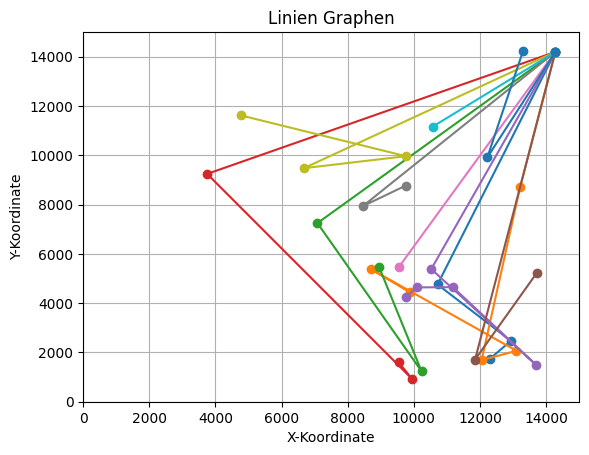

In [26]:
import matplotlib.pyplot as plt

# Plot erstellen
fig, ax = plt.subplots()

# Jede Linie zeichnen
for line_data in points:
    x = line_data['x']
    y = line_data['y']
    ax.plot(x, y, marker='o')  # Hier kannst du das Marker-Symbol anpassen, wenn gewünscht

# Achsentitel setzen
ax.set_xlabel('X-Koordinate')
ax.set_ylabel('Y-Koordinate')

# Titel setzen
ax.set_title('Linien Graphen')

# Legende hinzufügen
# ax.legend([f'Linie {i+1}' for i in range(len(points))])

# Grid anzeigen (optional)
ax.grid(True)

ax.set_xlim([0, 15000])
ax.set_ylim([0, 15000])

# Den Plot anzeigen
plt.show()


In [ ]:
# event_set = set()

# for match_id in lolwatcher.match.matchlist_by_puuid(region=server, puuid=puuid, count=1, queue=420):

#     time_line = lolwatcher.match.timeline_by_match(region=region, match_id=match_id)

#     for frame in time_line["info"]["frames"]:
#         for event in frame["events"]:
#             event_set.add(event["type"])

# event_set

In [ ]:
all_cs = []

for match_id in match_list[:45]:

    game_data = get_game_data(match_id)
    print(game_data["info"]["participants"][participant_index - 1]["championName"])
    game_duration = get_game_duration_m(game_data)

    if game_data["info"]["participants"][participant_index - 1]["teamPosition"] == "UTILITY":
        print("SKIP SUPPORT")
        continue

    time_line = get_time_line(match_id)
    participant_index = get_participant_index(time_line, puuid, is_time_line=True)

    cs = {}

    for i in range(game_duration + 2):
        participant = time_line["info"]["frames"][i]["participantFrames"][str(participant_index)]
        cs[f"cs@{i}"] = participant["jungleMinionsKilled"] + participant["minionsKilled"]
    
    cs["totalCs"] = cs[f"cs@{i}"]
    cs["gameDuration_s"] = (int(round(time_line["info"]["frames"][-1]["timestamp"] / 60000 * 60, 0)))

    all_cs.append(cs)

cs_df = pd.DataFrame(all_cs)
cs_df.head()

Ziggs
Rumble
Xerath
Alistar
SKIP SUPPORT
Gragas
Orianna
Jayce
Syndra
Syndra
Gragas
Ziggs
Yone
Syndra
Ahri
Jayce
Alistar
SKIP SUPPORT
Ahri
Syndra
Syndra
Senna
SKIP SUPPORT
Jayce
Syndra
Orianna
Alistar
SKIP SUPPORT
Xerath
Syndra
Gragas
Viktor
Alistar
SKIP SUPPORT
Syndra
Orianna
Gangplank
Syndra
Rumble
Jayce
Syndra
Syndra
Orianna
Syndra
Corki
Orianna
Syndra
Gangplank
Lissandra
Syndra


,cs@0,cs@1,cs@2,cs@3,cs@4,cs@5,cs@6,cs@7,cs@8,cs@9,cs@10,cs@11,cs@12,cs@13,cs@14,cs@15,cs@16,cs@17,cs@18,cs@19,cs@20,cs@21,cs@22,cs@23,cs@24,cs@25,cs@26,cs@27,cs@28,cs@29,totalCs,gameDuration_s,cs@30,cs@31,cs@32,cs@33,cs@34,cs@35,cs@36,cs@37,cs@38,cs@39,cs@40,cs@41,cs@42,cs@43,cs@44,cs@45,cs@46,cs@47,cs@48,cs@49
0,0,0,5,13,23,36,48,54.0,66.0,79.0,90.0,103.0,111.0,123.0,126.0,138.0,143.0,145.0,153.0,167.0,172.0,172.0,183.0,190.0,190.0,199.0,205.0,210.0,215.0,219.0,219,1712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,3,14,23,33,41,56.0,68.0,79.0,89.0,106.0,113.0,123.0,133.0,139.0,148.0,148.0,152.0,156.0,168.0,168.0,169.0,175.0,183.0,188.0,190.0,193.0,193.0,195.0,195,1718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,13,20,32,45,56.0,66.0,72.0,80.0,97.0,103.0,113.0,121.0,135.0,144.0,150.0,157.0,157.0,168.0,170.0,176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176,1285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,4,13,17,30,41,48.0,54.0,63.0,69.0,76.0,85.0,97.0,104.0,112.0,116.0,122.0,122.0,128.0,136.0,136.0,143.0,147.0,NaN,NaN,NaN,NaN,NaN,NaN,147,1361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,4,13,26,28,40,50.0,59.0,69.0,76.0,88.0,101.0,106.0,118.0,118.0,134.0,140.0,151.0,156.0,164.0,173.0,173.0,176.0,176.0,NaN,NaN,NaN,NaN,NaN,176,1383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cs_df["totalCs"].sum() / cs_df["gameDuration_s"].sum() * 60

7.658518386348521

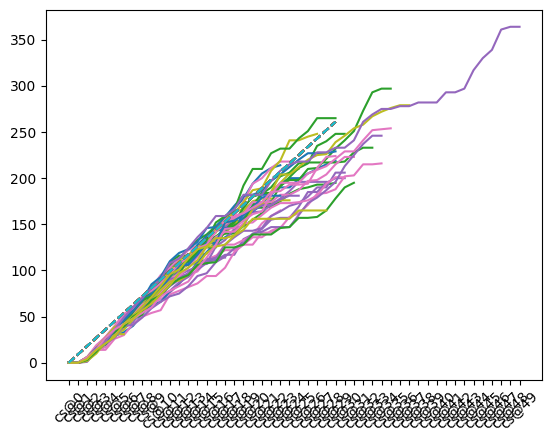

In [ ]:
for index, row in cs_df.iterrows():

    row.drop("totalCs", inplace=True)
    row.drop("gameDuration_s", inplace=True)

    plt.xticks(rotation=45)
    plt.plot(row, label=index)

    # # Generate x values
    # x_values = np.arange(0, 30)

    # # Define the function f(x) = 10x
    # def f(x):
    #     return 9 * x

    # # Calculate y values for the function
    # y_values_function = f(x_values)

    # plt.plot(x_values, y_values_function, label='10 cs / min', linestyle='--')

ValueError: x and y must have same first dimension, but have shapes (30,) and (2080,)

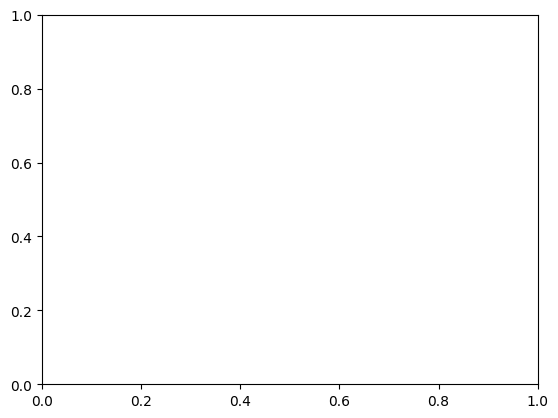

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Generate x values
x_values = np.arange(0, 30)

# Calculate y values for the given DataFrame
y_values_data = cs_df.values.flatten()

# Define the function f(x) = 10x
def f(x):
    return 10 * x

# Calculate y values for the function
y_values_function = f(x_values)

# Plot both the data and the function on the same graph
plt.plot(x_values, y_values_data, label='cs / min', linestyle='-')
plt.plot(x_values, y_values_function, label='10 cs / min', linestyle='--')

# Add labels and title
plt.xlabel('time in min')
plt.ylabel('cs')
plt.title('Graph of cs / min compared to "perfect" cs / min')

# Add legend
plt.legend()

# Display the plot
plt.show()
